In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torsionfit.database import qmdatabase as ScanSet
import torsionfit.model as Model
from torsionfit.backends import sqlite_plus
from torsionfit import parameters
from parmed.charmm import CharmmParameterSet, CharmmPsfFile
import torsionfit.parameters as par
import numpy as np
from edward.models import Normal, Categorical, Uniform, Empirical, TransformedDistribution
import tensorflow as tf
from simtk import unit
import copy
import edward as ed
#from edward.util import check_latent_vars, copy
from collections import OrderedDict



In [2]:
# Turn off dihedral energy for to get residuals 
param = CharmmParameterSet('../param/par_all36_cgenff.prm', '../param/top_all36_cgenff.rtf')
structure = '../structure/butane.psf'
struct_parmed = CharmmPsfFile(structure)
scan = '../torsion_scans/MP2_torsion_scan/'

dih_list = [('CG331', 'CG321', 'CG321', 'CG331'),
            ('HGA2', 'CG321', 'CG321', 'HGA2'),
           ('CG331', 'CG321', 'CG321', 'HGA2')]
par.turn_off_params(param=param, structure=struct_parmed, dihedral=dih_list, copy=False)


In [3]:
scan = ScanSet.parse_psi4_out(scan, structure, pattern='*.out2')
scan = scan.remove_nonoptimized()
scan.compute_energy(param)

[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~


/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:190: UserWarning: Warning: Optimizer failed for /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/10/butane_10.out2
  warnings.warn("Warning: Optimizer failed for {}".format(f))


[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/30/butane_30.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/40/butane_40.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/50/butane_50.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/60/butane_60.out2 WARNING] In logfilepa

[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/320/butane_320.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/330/butane_330.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/340/butane_340.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/350/butane_350.out2 WARNING] In l

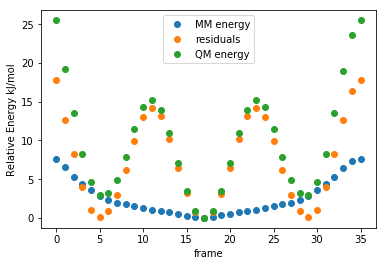

In [4]:
plt.plot(scan.mm_energy, 'o', label='MM energy')
plt.plot(scan.delta_energy, 'o', label='residuals')
plt.plot(scan.qm_energy, 'o', label='QM energy')
plt.legend()
plt.xlabel('frame')
plt.ylabel('Relative Energy kJ/mol')

In [5]:
# Edward Model No reversible jump
# TensorFlow interactive session
tf.InteractiveSession()

# Precalculate phis and cosines
to_optimize = [('CG331', 'CG321', 'CG321', 'CG331'),
              ('HGA2', 'CG321', 'CG321', 'HGA2'), 
              ('CG331', 'CG321', 'CG321', 'HGA2')]
scan.build_phis(to_optimize)
phis_np = np.zeros((36, 6, len(to_optimize)))
n_np = np.array([1., 2., 3., 4., 5., 6.])
# Precalculate 1+cos. This is also the gradient of the torsion energy with respect to K. 
# Question is, when I also want to sample over n, the gradient will be different. 
for i, t in enumerate(to_optimize):
    phis_np[:, :, i] = (1+np.cos(scan.phis[t][:, np.newaxis]*n_np[:, np.newaxis])).sum(-1)
phis = tf.constant(phis_np, dtype=tf.float32)  

# Model will fit to residuals
residual_data = tf.constant(copy.deepcopy(scan.delta_energy.value_in_unit(unit=unit.kilojoule_per_mole)), 
                            dtype=tf.float32)


/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:602: UserWarning: type frequency values don't sum up to number of dihedral
  warnings.warn("type frequency values don't sum up to number of dihedral")
/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:617: UserWarning: torsion ('HGA3', 'CG331', 'CG321', 'HGA2') is not in list of phis to precalculate but is in the structure. Are you sure you did not want to fit it?
  "Are you sure you did not want to fit it?".format(torsion_type))
/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:617: UserWarning: torsion ('HGA3', 'CG331', 'CG321', 'CG321') is not in list of phis to precalculate but is in the structure. Are you sure you did not wan

In [20]:
ds = tf.contrib.distributions
# K will have a normal prior with a Jefferey's prior on the precision
# Create priors for parameters
# Jeffery's priors on sigma

log_sgima_K = Uniform(low=tf.ones(len(to_optimize))*-4.6052, high=tf.ones(len(to_optimize))*3.453)
sigma_K = TransformedDistribution(distribution=log_sgima_K, bijector=ds.bijectors.Exp(), name='sigma_k')
K = Normal(loc=tf.zeros((len(n_np), len(to_optimize))), scale=1.0)
proposal_probs = {}
for i, t in enumerate(dih_list):
    name = t[0] + '_' + t[1] + '_' + t[2] + '_' + t[3]
    name_k = name + '_K'
    # create a scale with only one nonzero component in right position using i
    std = np.zeros((len(dih_list)), dtype='float32')
    std[i] = 1.0
    proposal_probs[name_k] = Normal(loc=K, scale=sigma_K[i]*std)
    name_sigma = name + '_sigma'
    proposal_probs[name_sigma] = Normal(loc=sigma_K, scale=std)

# Gaussian Likelihood with Jefferey's prior on sigma
log_sigma = Uniform(low=[-4.6052], high=[3.453])
sigma = TransformedDistribution(distribution=log_sigma, bijector=ds.bijectors.Exp(), name='sigma')
proposal_probs['sigma'] = Normal(loc=sigma, scale=1.0)
#sigma = tf.map_fn(lambda x: tf.exp(x), log_sigma)
#likelihood = Normal(loc=Fourier_sum, scale=sigma)

In [17]:
T = 1000
ds = tf.contrib.distributions
K = Normal(loc=tf.zeros((len(n_np), len(to_optimize))), scale=1.0)
Fourier_sum = tf.reduce_sum(tf.reduce_sum(tf.multiply(phis, K), axis=1), axis=1)
Fourier_sum_rel = Fourier_sum - tf.reduce_min(Fourier_sum)
proposal_K = Normal(loc=K, scale=0.03)
qK = Empirical(tf.Variable(tf.zeros([T, 6, 3])))
log_sigma = Uniform(low=[-4.6052], high=[3.453])
sigma = TransformedDistribution(distribution=log_sigma, bijector=ds.bijectors.Exp(), name='sigma')
proposal_sigma = Normal(loc=sigma, scale=0.03)
qsigma = Empirical(tf.Variable(tf.zeros([T, 1])))

In [18]:
%%time
# Fourier sum 
Fourier_sum = tf.reduce_sum(tf.reduce_sum(tf.multiply(phis, K), axis=1), axis=1)

CPU times: user 5.77 ms, sys: 222 µs, total: 5.99 ms
Wall time: 5.82 ms


In [19]:
likelihood = Normal(loc=Fourier_sum, scale=1.0)

In [20]:
# Set up HMC inference 
inference = ed.HMC(latent_vars=[K], data={likelihood: residual_data})

In [29]:
inference.initialize(step_size=0.000000001)

In [30]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 19s | Acceptance Rate: 0.000


In [ ]:
# Check what's going on with the gradient
